**Download the dataset**

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/msambare/fer2013")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhsinamunna
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


**Importing Required Libraries**

In [ ]:
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing import image

In [ ]:
warnings.filterwarnings("ignore")


**Defining Dataset Directories**

In [ ]:
dataset_path = "/content/fer2013"
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "test")


**Data Preprocessing & Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen =  ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    batch_size=64,
    class_mode="categorical",
    color_mode="grayscale",

)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48,48),
    batch_size=64,
    class_mode="categorical",
    color_mode="grayscale",

)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Visualizing Sample Images**

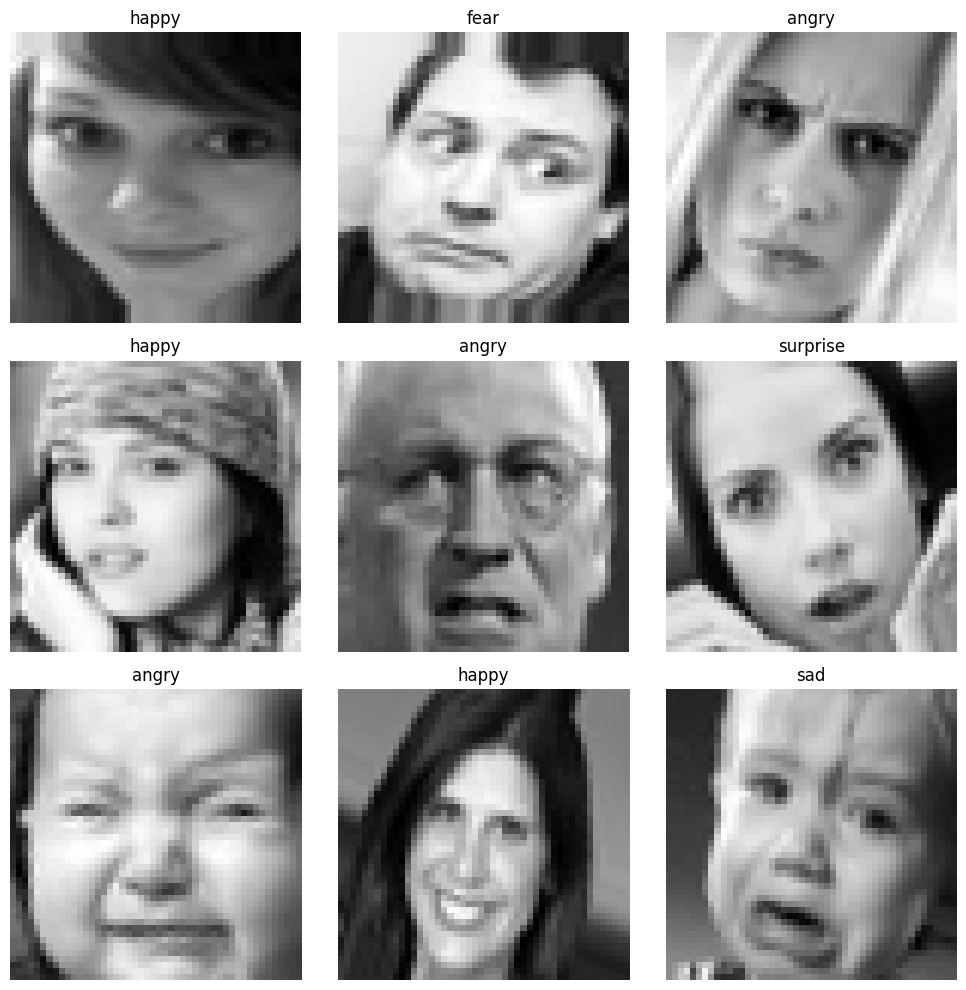

In [ ]:
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)

    img = images[i]  # Extract single image
    if img.shape[-1] == 1:  # Grayscale image
        plt.imshow(img.squeeze(), cmap="gray")
    else:  # RGB image
        plt.imshow(img)

    plt.title(class_names[np.argmax(labels[i])])  # Get class label
    plt.axis("off")

plt.tight_layout()
plt.show()

**Analyzing Class Distribution**

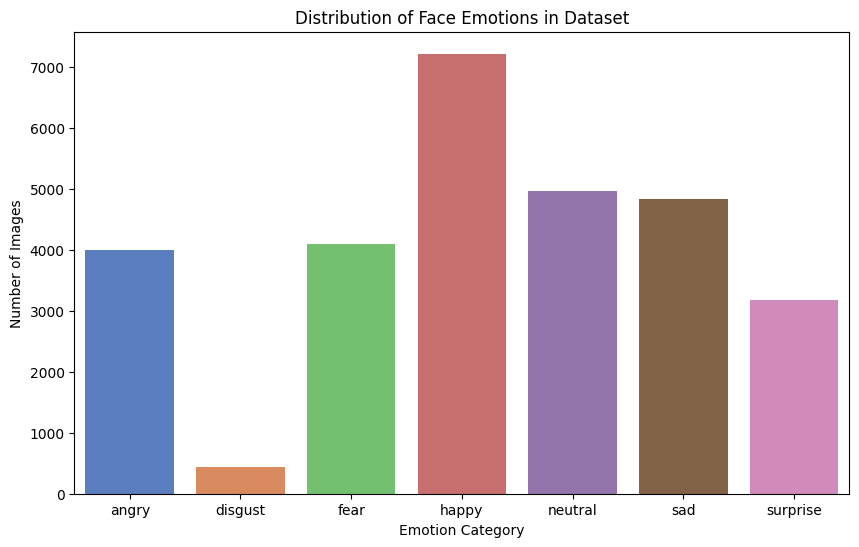

In [ ]:
class_names = list(train_generator.class_indices.keys())  # Emotion categories (e.g., Happy, Sad, etc.)
class_counts = Counter(train_generator.classes)  # Count of samples in each category

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="muted")
plt.title("Distribution of Face Emotions in Dataset")
plt.xlabel("Emotion Category")
plt.ylabel("Number of Images")
plt.xticks(ticks=range(len(class_names)), labels=[class_names[i] for i in range(len(class_names))])
plt.show()

**Defining the CNN Model Architecture**

In [ ]:
model = Sequential([
    Conv2D(64,(3,3),activation="relu",input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),


    Conv2D(128,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(512,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,474,759 (9.44 MB)

 Trainable params: 2,472,839 (9.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])

**Defining Callbacks**

In [ ]:
early_Stoping = EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=3,min_lr=1e-6,verbose=1)

**Training the Model**


In [ ]:
#model training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_Stoping,lr_scheduler]
)

Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.2349 - loss: 2.4095 - val_accuracy: 0.2449 - val_loss: 1.9514 - learning_rate: 0.0010
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 474s 998ms/step - accuracy: 0.3654 - loss: 1.6719 - val_accuracy: 0.2563 - val_loss: 2.6634 - learning_rate: 0.0010
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.4198 - loss: 1.5028 - val_accuracy: 0.4408 - val_loss: 1.4633 - learning_rate: 0.0010
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.4660 - loss: 1.3971 - val_accuracy: 0.5033 - val_loss: 1.2876 - learning_rate: 0.0010
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 479s 977ms/step - accuracy: 0.4827 - loss: 1.3508 - val_accuracy: 0.4858 - val_loss: 1.4399 - learning_rate: 0.0010
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 435s 961ms/step - accuracy: 0.4967 - loss: 1.3168 - val_accuracy: 0.4698 - val_loss: 1.3743 - learning_rate: 0.0010
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.5024 -

In [ ]:
model.save("/content/fer_project.keras")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

**Evaluating the Model**

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
              precision    recall  f1-score   support

       angry       0.40      0.50      0.44         4
     disgust       0.00      0.00      0.00         1
        fear       0.50      0.38      0.43         8
       happy       0.92      0.92      0.92        24
     neutral       0.58      0.70      0.64        10
         sad       0.69      0.69      0.69        13
    surprise       0.50      0.50      0.50         4

    accuracy                           0.70        64
   macro avg       0.51      0.53      0.52        64
weighted avg       0.69      0.70      0.70        64



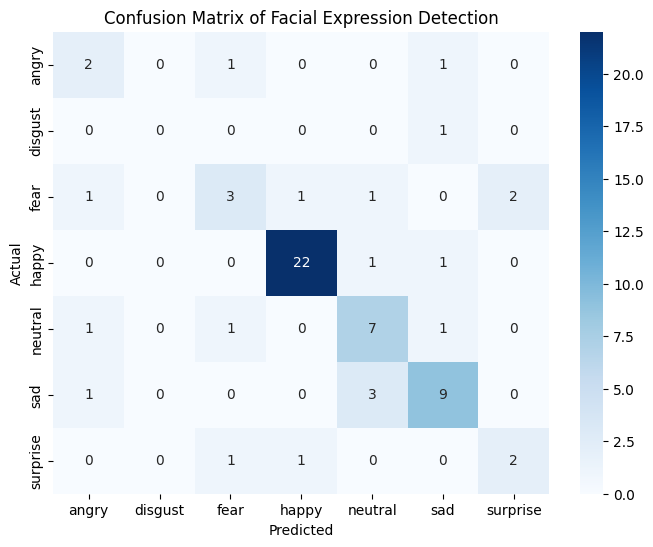

In [ ]:
val_images,val_labels = next(validation_generator)
predictions = model.predict(val_images)

y_true =np.argmax(val_labels,axis=1)
y_pred = np.argmax(predictions,axis=1)

print(classification_report(y_true,y_pred,target_names=class_names))
cm  =confusion_matrix(y_true,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues",xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Facial Expression Detection')
plt.show()

Happy faces were detected well (14 correct predictions).

Surprise and Neutral were also predicted fairly well.

Fear and Angry emotions had multiple misclassifications.

Disgust had no correctly classified samples

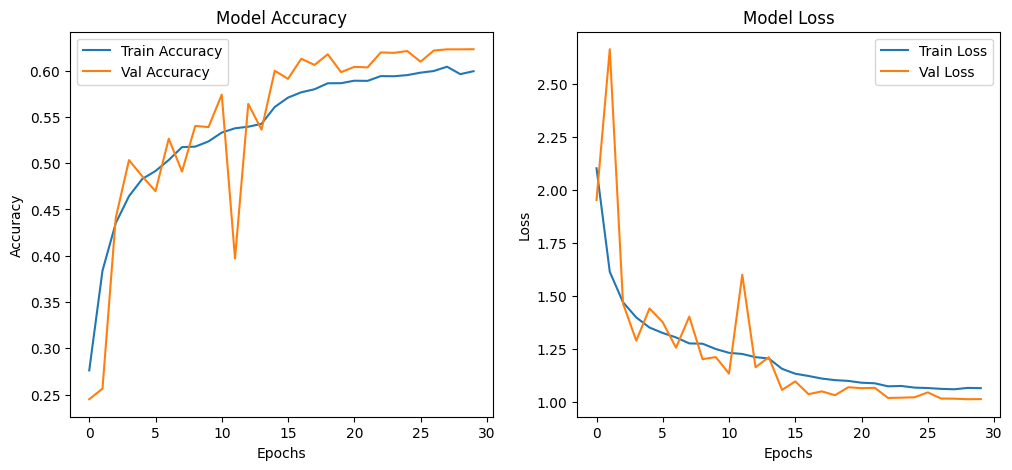

In [ ]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()
plot_metrics(history)

Validation accuracy fluctuates, meaning the model might struggle with generalization.
Validation loss is unstable, possibly due to an improper learning rate or data imbalance.


In [ ]:
# Evaluate the model on the FER-2013 test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.6199 - loss: 1.0155
Test Accuracy: 62.30%
Test Loss: 1.0113


In [ ]:
def detect_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = round(prediction[0][predicted_index] * 100, 2)  # Confidence in %

    # Display the image with the predicted label and confidence
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Emotion: {predicted_class} ({confidence}%)')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


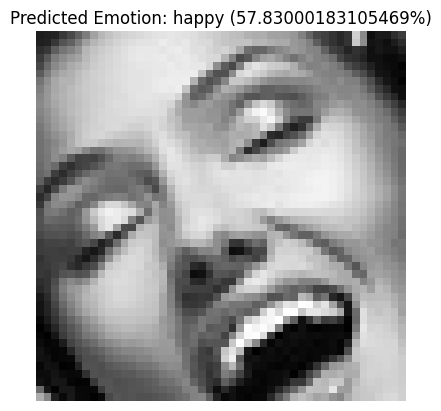

Emotion: happy, Confidence: 57.83000183105469%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/happy/PrivateTest_11070306.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


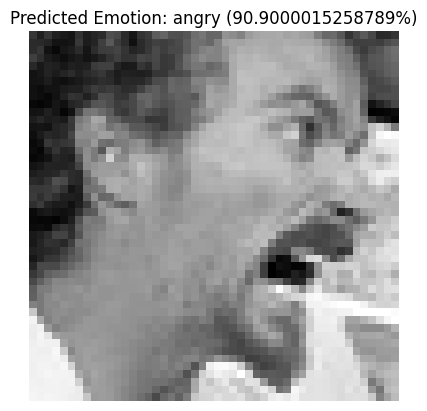

Emotion: angry, Confidence: 90.9000015258789%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/angry/PrivateTest_10304478.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


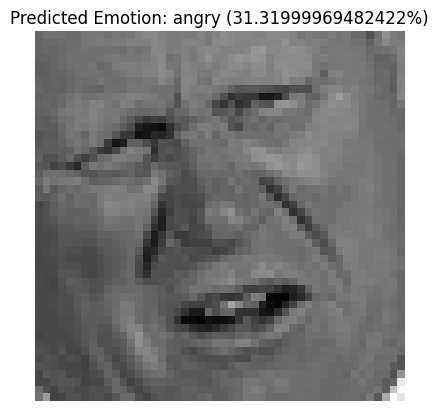

Emotion: angry, Confidence: 31.31999969482422%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/disgust/PrivateTest_34013087.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


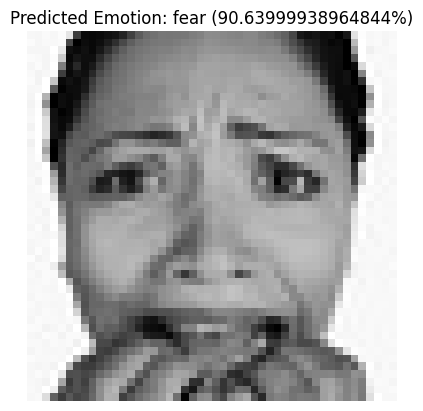

Emotion: fear, Confidence: 90.63999938964844%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/fear/PublicTest_94992549.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


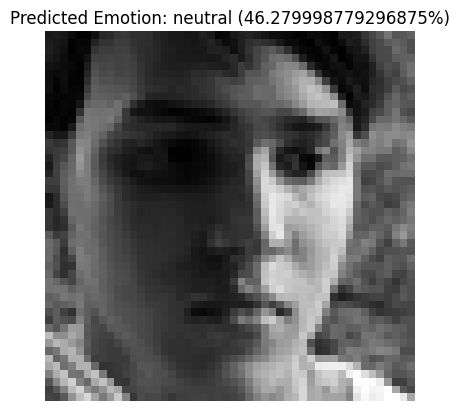

Emotion: neutral, Confidence: 46.279998779296875%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/neutral/PublicTest_69383833.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


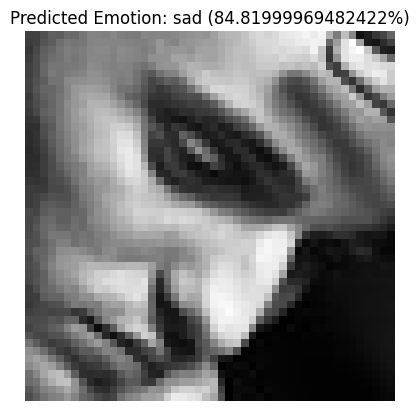

Emotion: sad, Confidence: 84.81999969482422%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/sad/PublicTest_64746852.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


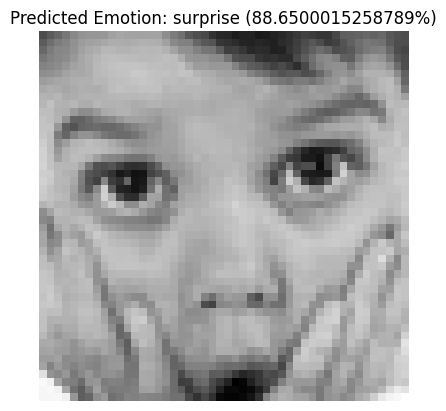

Emotion: surprise, Confidence: 88.6500015258789%


In [ ]:
predicted_emotion, confidence = detect_emotion(r'/content/fer2013/test/surprise/PublicTest_98972870.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

**Saving the model**

In [ ]:
model.save("/content/fer_cnn_project.keras")